In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import pcmdpy as ppy
from scipy.stats import lognorm
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
f = ppy.instrument.m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=False)

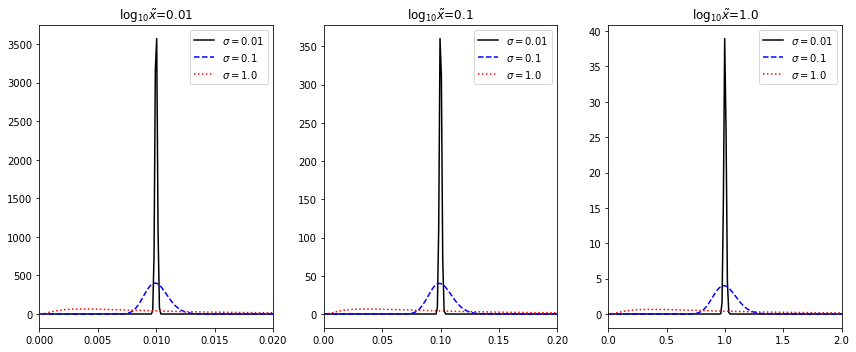

In [3]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
x = np.logspace(-4, 1, 1000)
mu = [0.01, 0.1, 1.]
sig = [0.01, 0.1, 1.]
for i, ax in enumerate(axes):
    ax.plot(x, lognorm.pdf(x, sig[0], scale=mu[i]), 'k-', label=r'$\sigma=$'+str(sig[0]))
    ax.plot(x, lognorm.pdf(x, sig[1], scale=mu[i]), 'b--', label=r'$\sigma=$'+str(sig[1]))
    ax.plot(x, lognorm.pdf(x, sig[2], scale=mu[i]), 'r:', label=r'$\sigma=$'+str(sig[2]))
    ax.legend(loc=0)
    ax.set_title(r'$\log_{10}\tilde{x}$='+str(mu[i]))
axes[0].set_xlim([0, 0.02])
axes[1].set_xlim([0, 0.2])
axes[2].set_xlim([0, 2.])
plt.tight_layout()

In [4]:
mu = [-2., -1., 0.]
sig = [0.1, 0.3, 1.]

In [5]:
gm = ppy.galaxy.CustomGalaxy(ppy.metalmodels.SingleFeH, ppy.dustmodels.LogNormDust, ppy.agemodels.SSPModel)
gals = [[gm.get_model(np.array([0., a, b, 5., 10])) for b in sig] for a in mu]

In [6]:
nr = len(mu)
nc = len(sig)

In [7]:
pcmds = [[driv.simulate(gals[i][j], 128, psf=True)[0] for j in range(nc)] for i in range(nr)]

In [8]:
ims = [driv.simulate(gm.get_model(np.array([0., -.5, s, 5., 10.])), 128, psf=True)[1] for s in [0.1, 1.0]]

In [14]:
pcmds_all = np.hstack(np.vstack(pcmds))
bins = [np.linspace(pcmds_all[1].min(), pcmds_all[1].max(), 100), np.linspace(pcmds_all[0].min(), pcmds_all[0].max(), 100)]

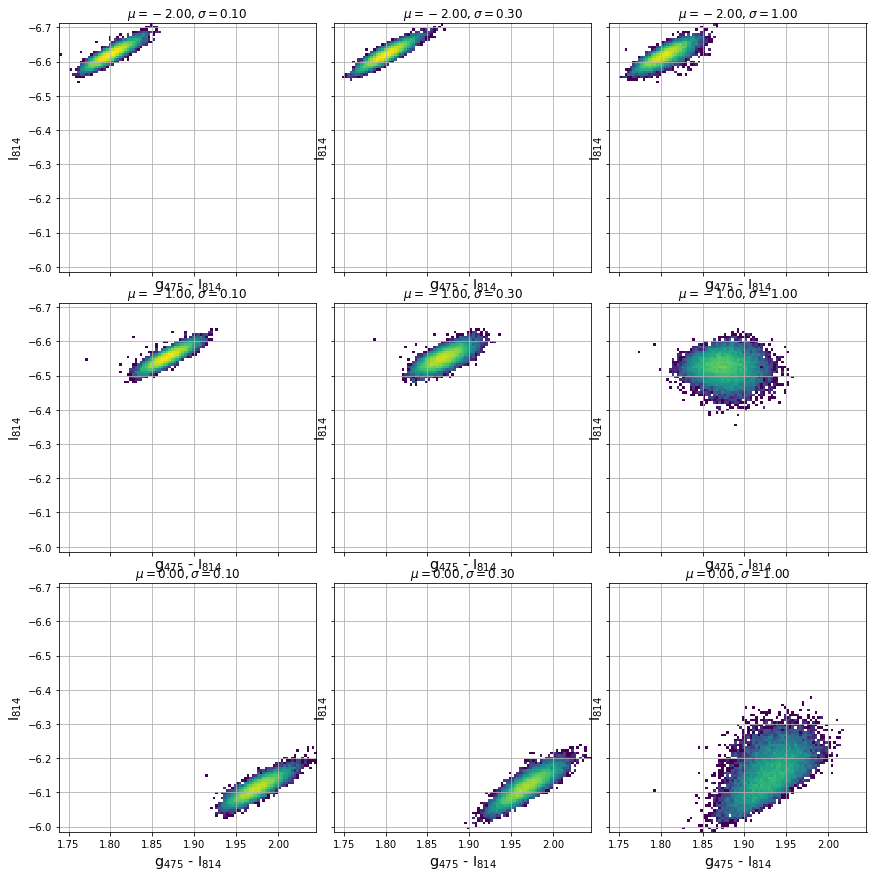

In [15]:
fig, axes = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 12), sharex=True, sharey=True)
n = mpl.colors.LogNorm()
for i in range(nr):
    for j in range(nc):
        ax = axes[i, j]
        plt.subplot(ax)
        pcmd = pcmds[i][j]
        plt.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n)
        ax.set_title(r'$\mu = {:.2f}, \sigma = {:.2f}$'.format(mu[i], sig[j]))
plt.tight_layout()
for a in axes.flatten(): 
    a.grid(True)
    iso_model.plot_isochrone(gals[0][0], axes=a)
plt.savefig('figures/lognorm_dust_pcmds.pdf')

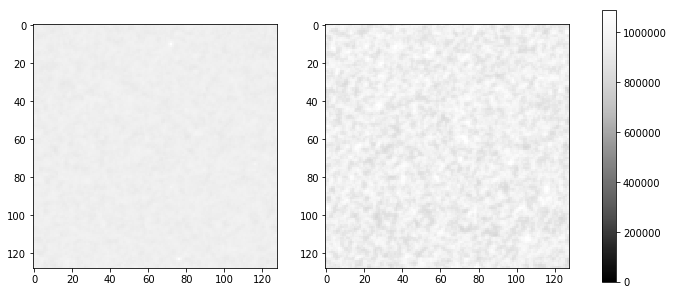

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
n = mpl.colors.Normalize(vmin=0.)
plt.subplot(axes[0])
plt.imshow(ims[0][1], norm=n, cmap='Greys_r')
plt.subplot(axes[1])
plt.imshow(ims[1][1], norm=n, cmap='Greys_r')
plt.colorbar(ax=axes)
plt.savefig('figures/lognorm_dust_ims.pdf')

In [12]:
def pixel_scale(d_mpc):
    d = d_mpc * 1e6
    theta = 0.5 #arcsec
    theta /= 3600. # degrees
    theta *= (np.pi / 180.) #radians
    s_pix = theta * d
    print('pixel scale at {:.1f} Mpc is: {:.1f} pc'.format(d_mpc, s_pix))

In [13]:
pixel_scale(20.)

pixel scale at 20.0 Mpc is: 48.5 pc
